# [Hull White Term Structure Simulations with QuantLib](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html)
[Gouthaman Balaraman](http://gouthamanbalaraman.com)

The Hull-White Short Rate Model is defined as:

$$ dr_t = (\theta(t) - a r_t)dt + \sigma dW_t $$

where $a$ and $ \sigma $ are constants, and $\theta(t)$ is
chosen in order to fit the input term structure of interest rates.
Here we use QuantLib to show how to simulate the Hull-White model
and investigate some of the properties.

We import the libraries and set things up as shown below:

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

The constants that we use for this example is all defined as shown below.
Variables `sigma` and `a` are the constants that define the Hull-White
model. In the simulation, we discretize the time span of `length` 30 years
into 360 intervals (one per month) as defined by the `timestep` variable.
For simplicity we will use a constant forward rate term structure as an
input. It is straight forward to swap with another term structure here.

In [2]:
sigma = 0.1
a = 0.1
timestep = 360
length = 30 # in years
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2015)

In [3]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [4]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

The Hull-White process is constructed by passing the term-structure, `a` and
`sigma`. To create the path generator, one has to provide a random sequence generator
along with other simulation inputs such as `timestep` and `length.

A function to generate paths can be written as shown below:

In [5]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

The simulation of the short rates look as shown below:

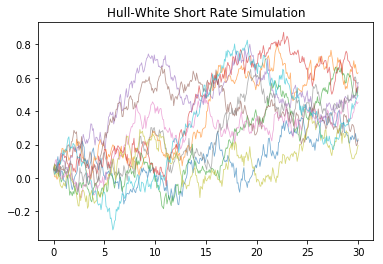

In [6]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

The short rate $r(t)$ is given a distribution with the properties:

$$ E\{r(t) | F_s\} = r(s)e^{-a(t-s)}  + \alpha(t) - \alpha(s)e^{-a(t-s)} $$
   $$ Var\{ r(t) | F_s \} = \frac{\sigma^2}{2a} [1 - e^{-2a(t-s)}] $$
   where 
   $$ \alpha(t) = f^M(0, t) + \frac{\sigma^2} {2a^2}(1-e^{-at})^2$$
   
as shown in Brigo & Mercurio's book on Interest Rate Models.

In [7]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)

The mean and variance compared between the simulation (red dotted line) and theory (blue line).

Text(0.5,1,'Variance of Short Rates')

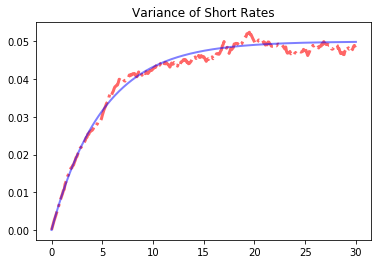

In [8]:
vol = [np.var(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, vol, "r-.", lw=3, alpha=0.6)
plt.plot(time,sigma*sigma/(2*a)*(1.0-np.exp(-2.0*a*np.array(time))), "b-", lw=2, alpha=0.5)
plt.title("Variance of Short Rates")

Text(0.5,1,'Mean of Short Rates')

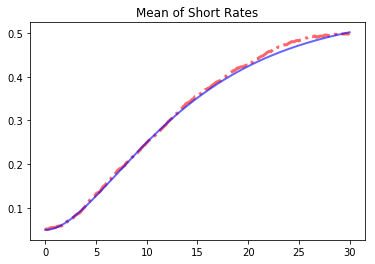

In [9]:
def alpha(forward, sigma, a, t):
    return forward + 0.5* np.power(sigma/a*(1.0 - np.exp(-a*t)), 2)

avg = [np.mean(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, avg, "r-.", lw=3, alpha=0.6)
plt.plot(time,alpha(forward_rate, sigma, a, time), "b-", lw=2, alpha=0.6)
plt.title("Mean of Short Rates")